# 问题分析 

- 目标：利用个人基本信息和通话特诊，预测用户是否为电信欺诈用户


- 直觉判断：
1. 欺诈用户的年龄不能太大也不能太小；
2. 欺诈用户不太可能是校园用户；
3. 欺诈行为的发生不太可能在夜间；
4. 欺诈用户的被叫次数应该较少，呼出次数较多；
5. 欺诈用户工作日与节假日的交往圈重合度应该较高；
6. 欺诈用户仅拨打一次的电话号码的数量较多，占比较高；
7. 欺诈用户的联系人top5/top10通话时长占比较少、次数占比较少、归属地数量较多；

- 任务类型：有监督的二分类任务

- 评估指标：
1. Precision；（不好）
2. Recall；（不好）
3. F-beta-score（可设置beta>1使得查全率影响高，因为我们需要低精确度、高查全率）；
4. P-R曲线
4. ROC曲线/AUC（排序的质量）（不好）；
5. 代价曲线（欺诈行为发生频率低但的代价高）；

- 问题：样本不均衡    
1. 验证集的划分（分层）
2. 评估指标的选择
3. 过拟合？

# 研究数据

In [1508]:
import pandas as pd
from matplotlib import pyplot as plt

In [1509]:
train = pd.read_csv('./data/training.csv')

In [1510]:
data = train.copy()

In [1511]:
data

,age,sex,is_camp_user,night_call_dura_rate,night_call_cnt_rate,called_cnt_rate,contact_ratio,once_numbers,once_numbers_rate,top5_call_dura_rate,top5_call_cnt_rate,top5_opp_belo_cnt,top10_call_dura_rate,top10_call_cnt_rate,top10_opp_belo_cnt,label
0,25,2,0,1.2726,3.1250,87.5000,1,2,66.6667,72.0020,43.7500,3,86.5884,62.5000,3,0
1,18,2,0,8.4315,6.9767,76.7442,3,3,50.0000,99.2148,88.3721,1,100.0000,100.0000,3,0
2,42,1,1,5.0105,7.6923,49.0385,7,13,65.0000,64.1474,53.8462,2,82.2526,71.1538,3,0
3,28,2,1,1.4925,3.8462,19.2308,0,21,100.0000,45.9242,19.2308,1,64.0643,38.4615,1,0
4,60,1,0,0.7424,0.6472,37.5405,15,12,37.5000,69.9878,57.2816,3,85.1415,70.8738,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29404,22,2,0,6.3073,20.0000,100.0000,0,0,0.0000,100.0000,100.0000,3,100.0000,100.0000,3,0
29405,0,1,1,5.4694,6.1224,43.8776,5,1,20.0000,99.0246,89.7959,3,99.8302,97.9592,3,0
29406,18,1,0,4.6768,7.4074,48.1481,4,13,54.1667,45.3232,27.1605,1,62.7430,41.9753,1,0
29407,34,1,0,0.3208,0.7299,27.7372,9,7,35.0000,82.2456,62.7737,2,91.2374,74.4526,2,0


In [1512]:
data.info()
# 注意rate特征的单位是%

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29409 entries, 0 to 29408
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   29409 non-null  int64  
 1   sex                   29409 non-null  int64  
 2   is_camp_user          29409 non-null  int64  
 3   night_call_dura_rate  29409 non-null  float64
 4   night_call_cnt_rate   29409 non-null  float64
 5   called_cnt_rate       29409 non-null  float64
 6   contact_ratio         29409 non-null  int64  
 7   once_numbers          29409 non-null  int64  
 8   once_numbers_rate     29409 non-null  float64
 9   top5_call_dura_rate   29409 non-null  float64
 10  top5_call_cnt_rate    29409 non-null  float64
 11  top5_opp_belo_cnt     29409 non-null  int64  
 12  top10_call_dura_rate  29409 non-null  float64
 13  top10_call_cnt_rate   29409 non-null  float64
 14  top10_opp_belo_cnt    29409 non-null  int64  
 15  label              

In [1513]:
data['contact_ratio']
# 这个重合度指的应该是拨打对象相同的人数

0         1
1         3
2         7
3         0
4        15
         ..
29404     0
29405     5
29406     4
29407     9
29408     8
Name: contact_ratio, Length: 29409, dtype: int64

总体数据特征分布分析：
- 样本的年龄主要分布在20-60之间，20-40间居多；

- 样本的性别分布不是太均衡；
- 样本主要为非校园用户；
- 大部分样本的夜间通话时长/次数占比低于10%，可能说明欺诈用户的夜间通话时长/次数占比高（经验证该猜想错误）；
- 夜间通话时长/次数占比指标分布相似（相关性较高），考虑进行特征处理；
- 被呼叫次数占比分布近似高斯分布，处在分布两端特别是偏低的那一部分可能是欺诈用户（经过验证，偏低的那一部分是欺诈用户的可能性高，偏高那部分是欺诈用户的可能性较低）；
- 大部分样本的工作日与节假日交往圈重合度较低，说明重合度较高的用户可能是欺诈用户（经验证该猜想错误）；
- 大部分样本仅拨打一次的电话的数量较低（小于10次），有个别甚至超过3000次，该指标超过50则是欺诈用户的可能性大；
- 仅拨打一次电话的数量占比分布呈现“W”形状，分布两头的部分可能是欺诈用户（已验证）；
- 联系人top5通话时长占比分布呈递增趋势，占比较低那部分可能是欺诈用户（已验证）；
- 联系人top5通话次数占比大部分集中在50%-90%，占比较低那部分可能是欺诈用户（已验证）；
- 联系人top5号码归属地数量主要集中在1-3，4-5可能为欺诈用户（经验证该猜想错误）；
- top10的通话时长占比分布和次数占比分布相似，top10的通话时长占比分布与top5相似，但次数占比分布相似与top5不相似，考虑特征处理；
- 联系人top10号码归属地数量主要集中在5以内，尾部用户可能是欺诈用户（已验证）
- 样本标签分布不均衡（任务性质决定），需要在划分验证集是根据标签进行分层；

In [1514]:
data.describe()

,age,sex,is_camp_user,night_call_dura_rate,night_call_cnt_rate,called_cnt_rate,contact_ratio,once_numbers,once_numbers_rate,top5_call_dura_rate,top5_call_cnt_rate,top5_opp_belo_cnt,top10_call_dura_rate,top10_call_cnt_rate,top10_opp_belo_cnt,label
count,29409.000000,29409.000000,29409.000000,29409.000000,29409.000000,29409.000000,29409.000000,29409.000000,29409.000000,29409.000000,29409.000000,29409.000000,29409.000000,29409.000000,29409.000000,29409.000000
mean,38.884117,1.437145,0.152334,6.363872,6.413430,54.902482,5.971097,9.149852,50.161633,78.063901,63.742208,1.773607,89.729674,80.216229,2.415043,0.054779
std,14.410745,0.516132,0.359351,12.279179,9.553943,19.472407,6.673715,45.361686,24.079010,18.532458,22.256341,0.897999,14.951446,19.569954,1.384936,0.227553
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,1.000000,0.000000,0.537600,1.492500,43.478300,2.000000,2.000000,35.714300,67.859700,48.507500,1.000000,85.957200,70.192300,1.000000,0.000000
50%,39.000000,1.000000,0.000000,1.886800,3.333300,54.567300,4.000000,5.000000,50.000000,81.827300,65.306100,2.000000,94.958600,84.729100,2.000000,0.000000
75%,50.000000,2.000000,0.000000,6.142100,7.407400,66.666700,8.000000,9.000000,64.864900,92.579600,80.663000,2.000000,99.419400,96.103900,3.000000,0.000000
max,117.000000,3.000000,1.000000,100.000000,100.000000,100.000000,347.000000,3260.000000,100.000000,100.000000,100.000000,5.000000,100.000000,100.000000,10.000000,1.000000


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'sex'}>,
        <AxesSubplot:title={'center':'is_camp_user'}>,
        <AxesSubplot:title={'center':'night_call_dura_rate'}>],
       [<AxesSubplot:title={'center':'night_call_cnt_rate'}>,
        <AxesSubplot:title={'center':'called_cnt_rate'}>,
        <AxesSubplot:title={'center':'contact_ratio'}>,
        <AxesSubplot:title={'center':'once_numbers'}>],
       [<AxesSubplot:title={'center':'once_numbers_rate'}>,
        <AxesSubplot:title={'center':'top5_call_dura_rate'}>,
        <AxesSubplot:title={'center':'top5_call_cnt_rate'}>,
        <AxesSubplot:title={'center':'top5_opp_belo_cnt'}>],
       [<AxesSubplot:title={'center':'top10_call_dura_rate'}>,
        <AxesSubplot:title={'center':'top10_call_cnt_rate'}>,
        <AxesSubplot:title={'center':'top10_opp_belo_cnt'}>,
        <AxesSubplot:title={'center':'label'}>]], dtype=object)

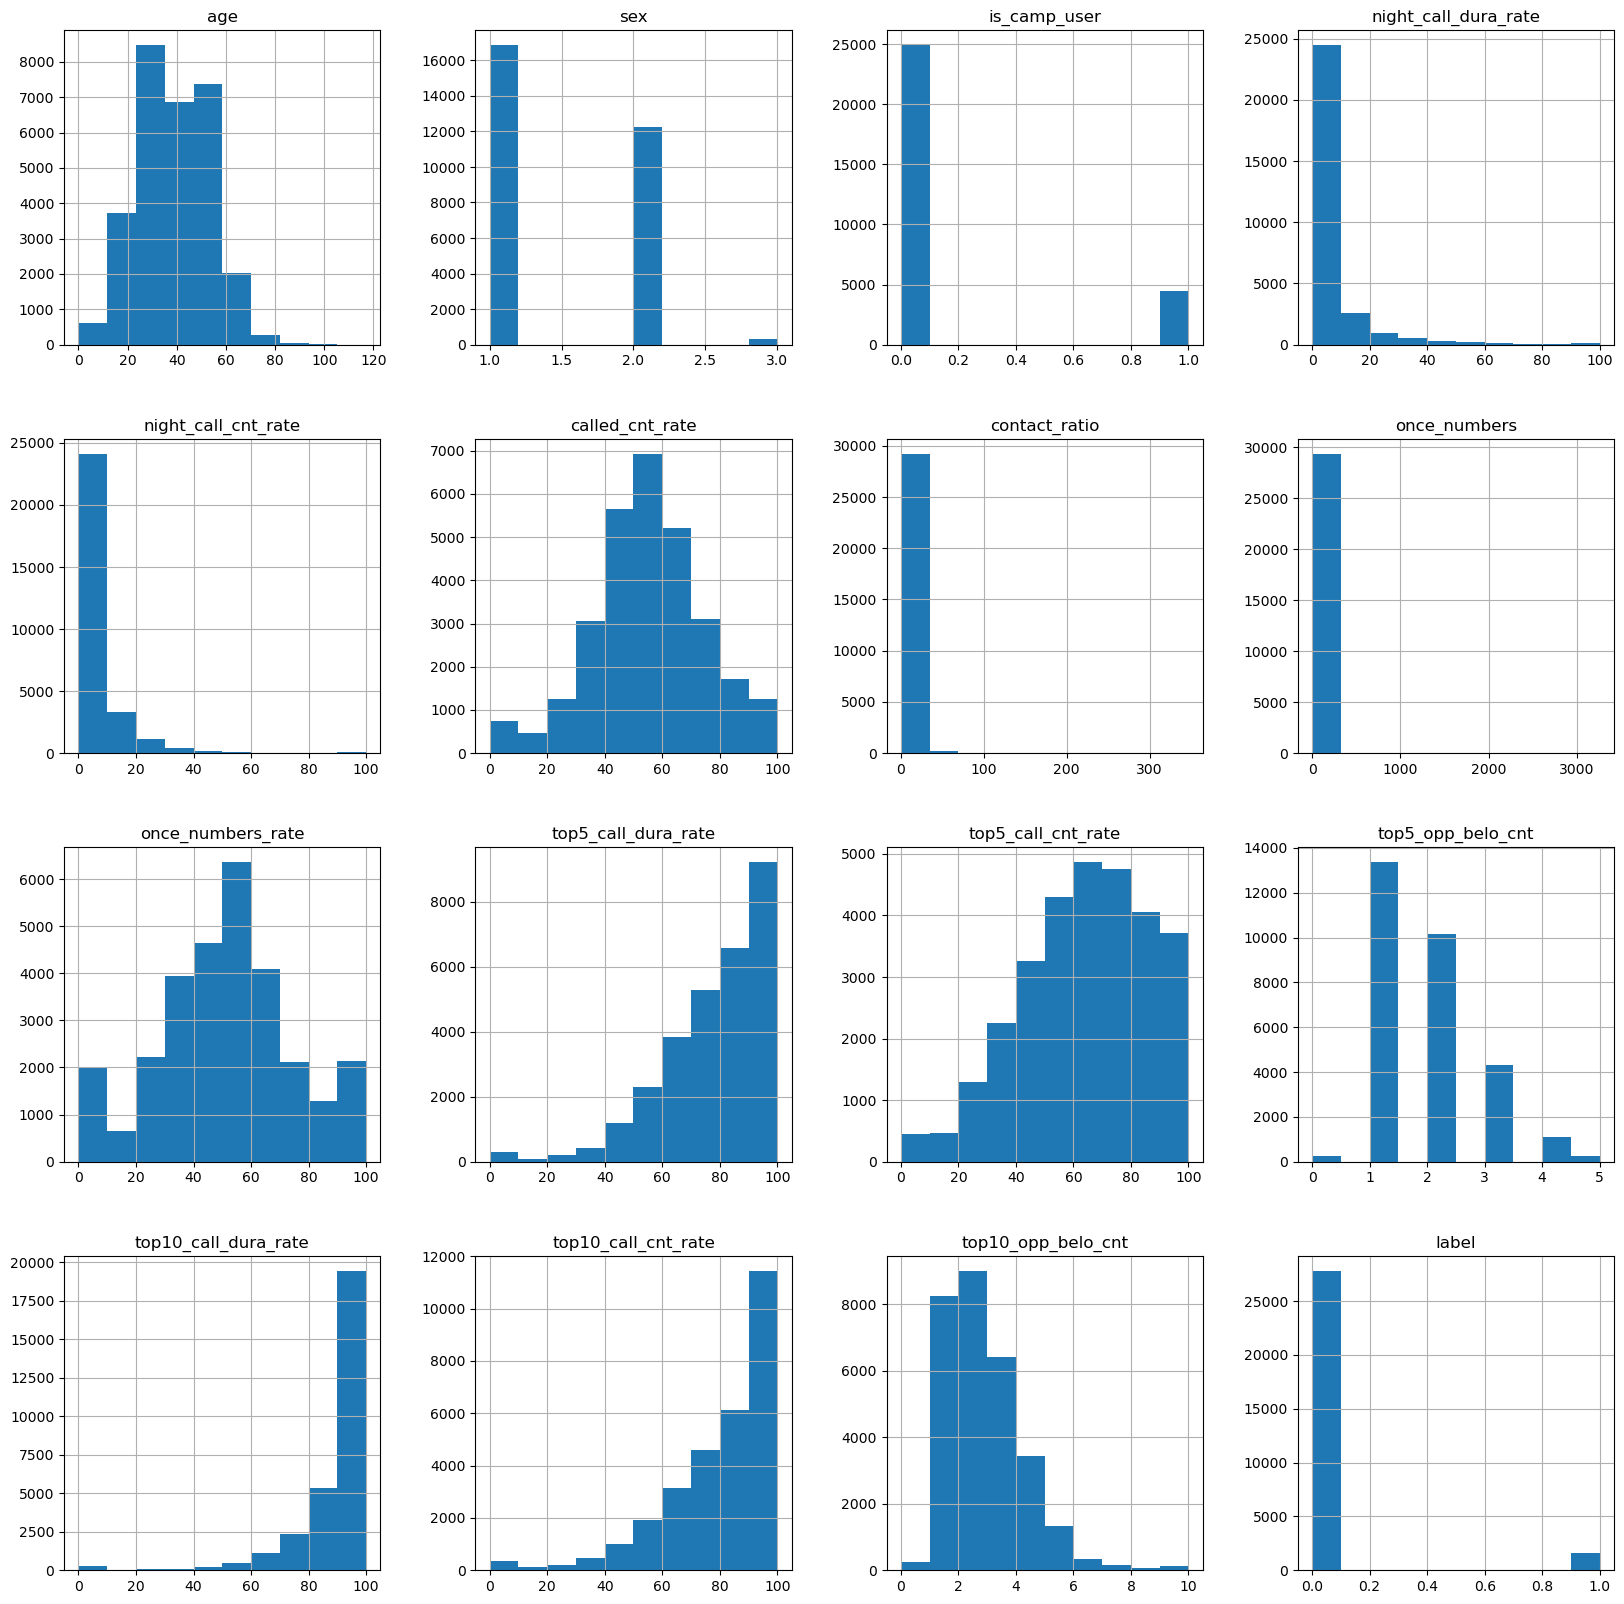

In [1515]:
data.hist(figsize=(20,20))

In [1516]:
normal = data[data['label']==0]
cheat = data[data['label']==1]

- 异常用户与正常用户分布不同的特征：
1. 被呼叫次数占比:：欺诈用户的被呼叫次数较少；
2. 一次通话数量占比：欺诈用户分布两头较中间高；
3. 一次通话数量：欺诈用户的一次通话数量高于100；
4. 联系人top5/10 通话时长占比(%)：较低那头是欺诈用户的可能性高;
5. 联系人top5/10 通话次数占比(%)：较低那头是欺诈用户的可能性高;
6. 联系人top5/10 号码归属地数量：归属地数量多的那部分是欺诈用户的可能性高;

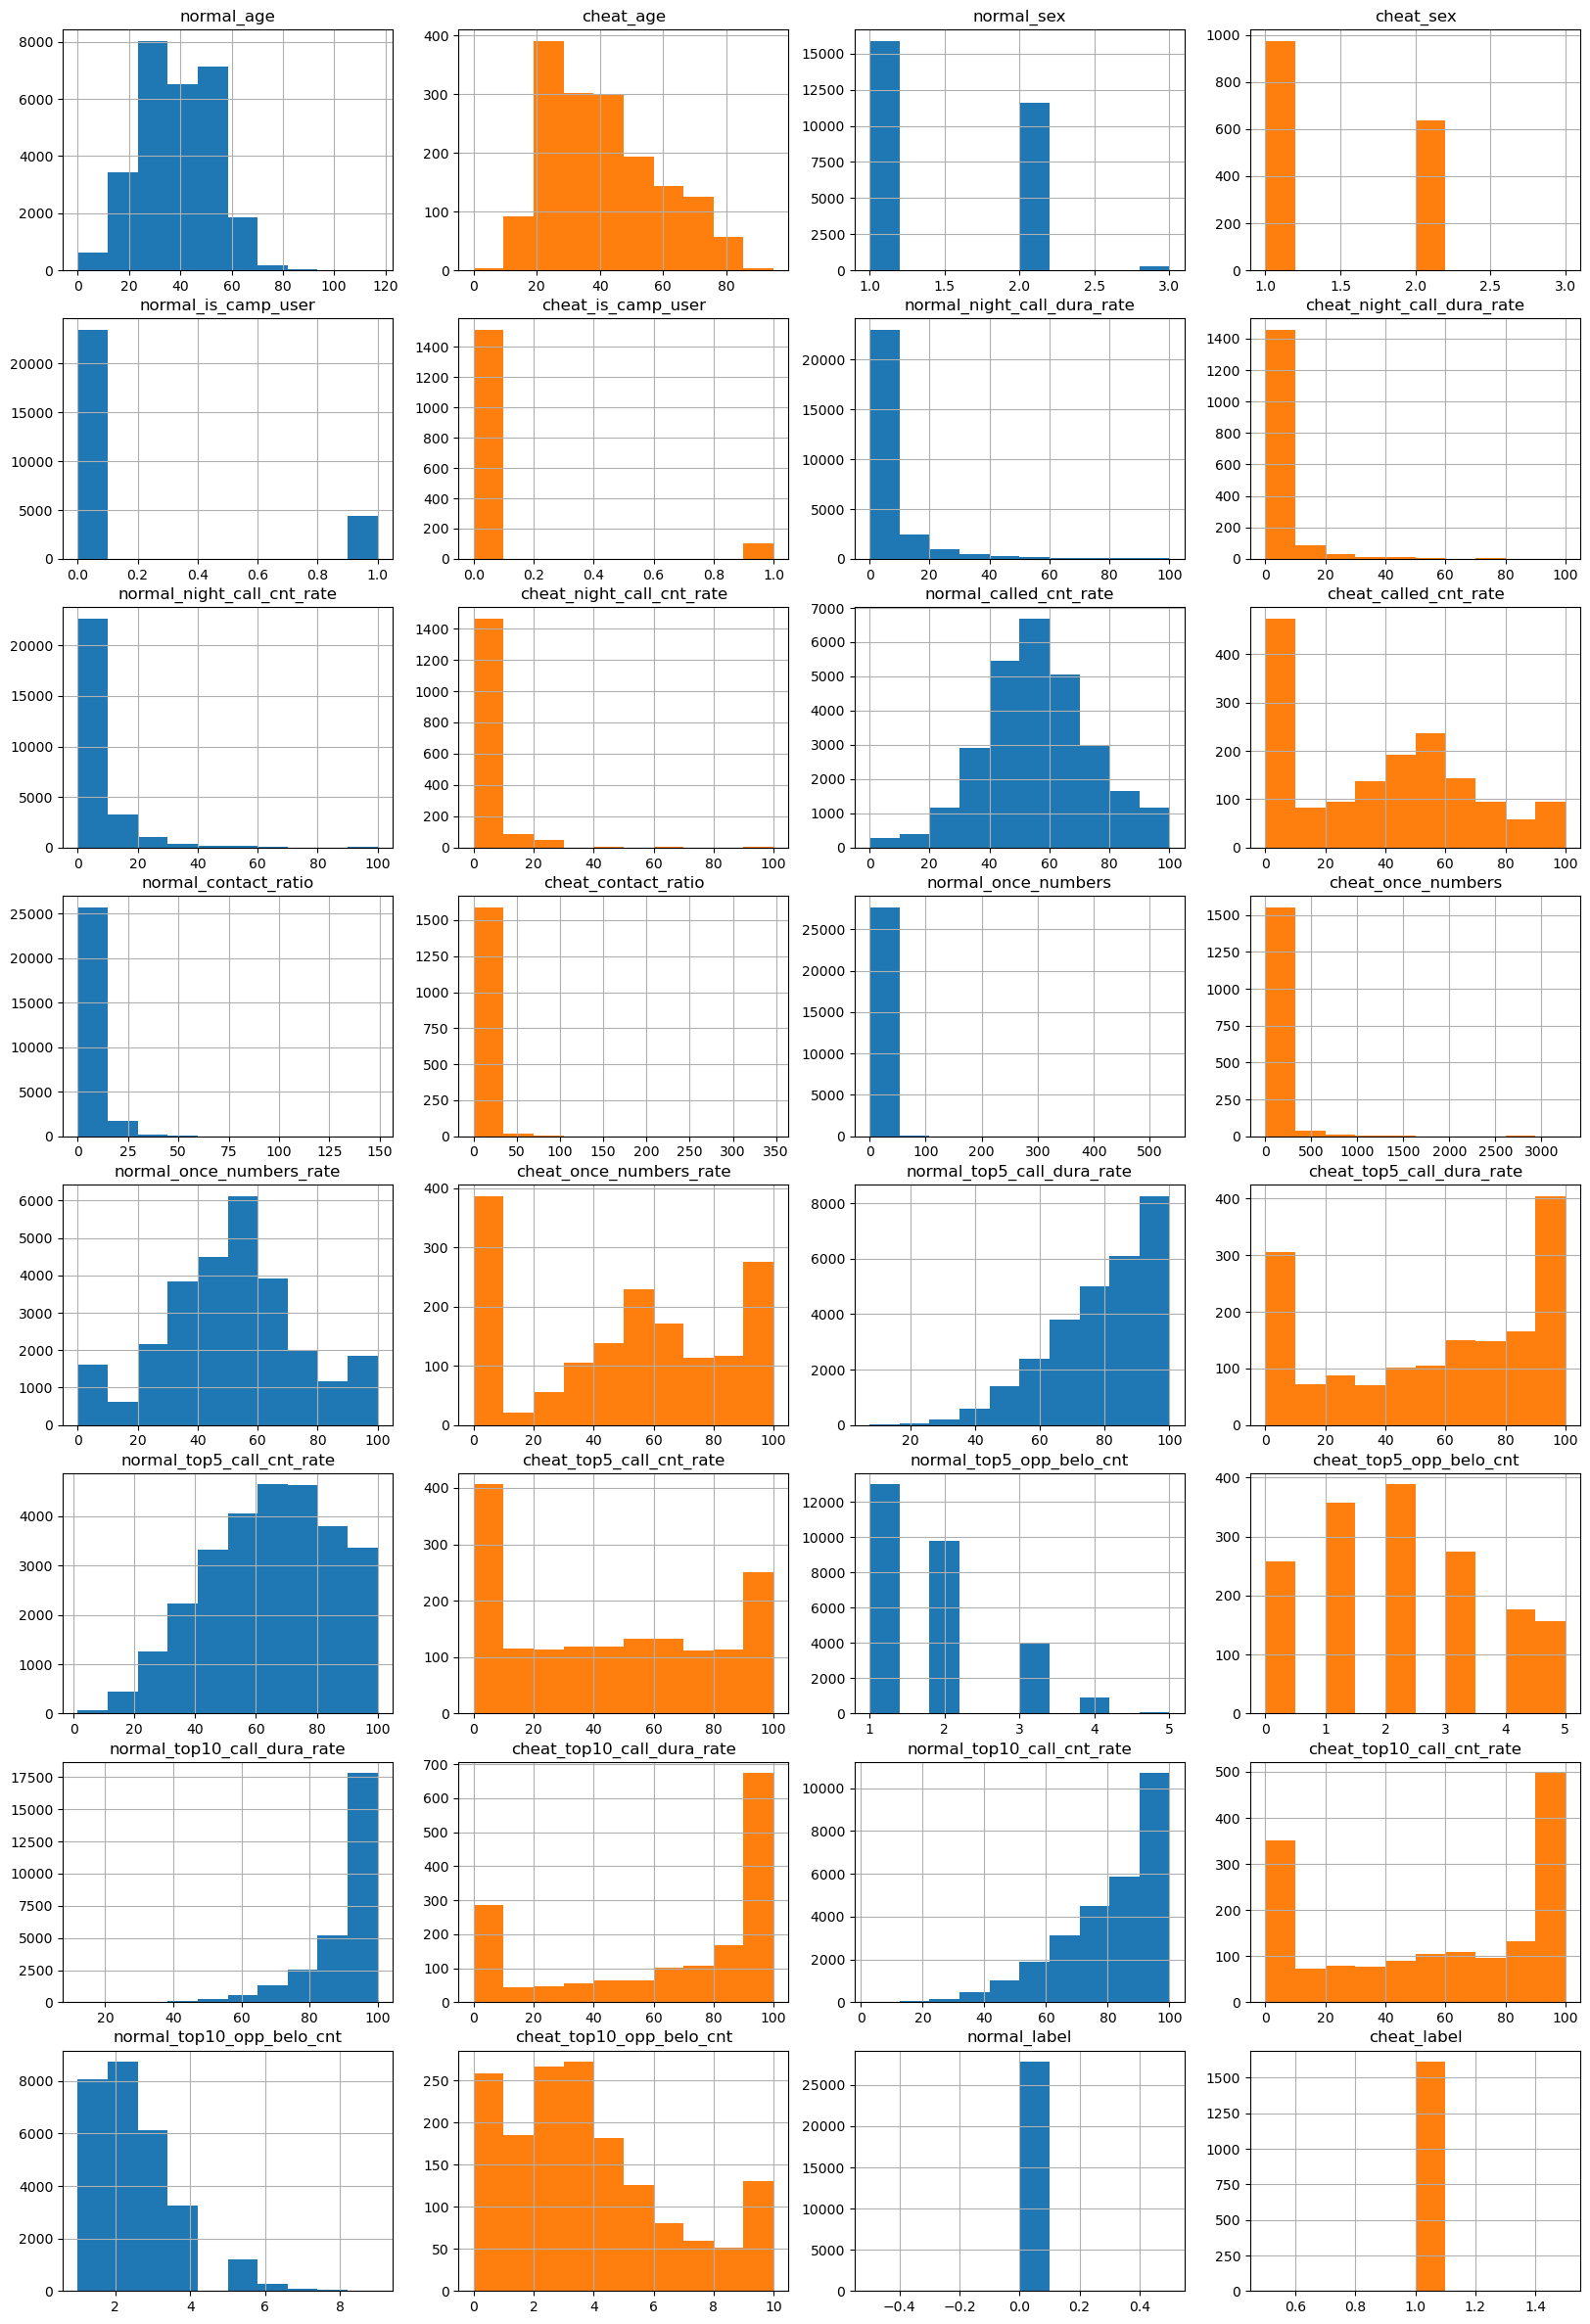

In [1540]:
fig = plt.figure(figsize=(20,30))
for index, columns in enumerate(data.columns):
    ax1 = fig.add_subplot(int(len(data.columns)/2),4,index*2+1)
    ax1 = normal[columns].hist()
    plt.title('normal_'+columns)
    ax2 = fig.add_subplot(int(len(data.columns)/2),4,index*2+2)
    ax2 = cheat[columns].hist(color='C1')
    plt.title('cheat_'+columns)

综上所述：
- 夜间通话时长/次数占比指标分布相似（相关性较高），考虑进行特征处理；
- top10的通话时长占比分布和次数占比分布相似，top10的通话时长占比分布与top5相似，但次数占比分布相似与top5不相似，考虑特征处理；
- 划分验证集时标签分层;

- 被呼叫次数偏低的那一部分是欺诈用户的可能性高；
- 仅拨打一次电话的数量比例分布呈现“W”形状，分布两头的部分可能是欺诈用户；
- 仅拨打一次电话的数量高于100的可能是欺诈用户；
- 联系人top5/10 通话时长占比(%)：较低那头是欺诈用户的可能性高;
- 联系人top5/10 通话次数占比(%)：较低那头是欺诈用户的可能性高;
- 联系人top5/10 号码归属地数量：归属地数量多的那部分是欺诈用户的可能性高;

查看属性之间的相关性

In [123]:
corr_matrix = data.corr()

In [124]:
corr_matrix['label']
# 各特征与label的相关系数同样支持上述猜想

age                     0.032195
sex                    -0.019179
is_camp_user           -0.060469
night_call_dura_rate   -0.061763
night_call_cnt_rate    -0.090736
called_cnt_rate        -0.209620
contact_ratio          -0.036284
once_numbers            0.210248
once_numbers_rate      -0.009041
top5_call_dura_rate    -0.280738
top5_call_cnt_rate     -0.197689
top5_opp_belo_cnt       0.097469
top10_call_dura_rate   -0.389707
top10_call_cnt_rate    -0.295857
top10_opp_belo_cnt      0.166961
label                   1.000000
Name: label, dtype: float64

In [125]:
abs(corr_matrix['label']).sort_values(ascending=False)
# once_numbers_rate的相关系数低可能是因为处在分布两头的用户是欺诈用户的可能性高于中部，或者说该特征与label没有线性相关性

label                   1.000000
top10_call_dura_rate    0.389707
top10_call_cnt_rate     0.295857
top5_call_dura_rate     0.280738
once_numbers            0.210248
called_cnt_rate         0.209620
top5_call_cnt_rate      0.197689
top10_opp_belo_cnt      0.166961
top5_opp_belo_cnt       0.097469
night_call_cnt_rate     0.090736
night_call_dura_rate    0.061763
is_camp_user            0.060469
contact_ratio           0.036284
age                     0.032195
sex                     0.019179
once_numbers_rate       0.009041
Name: label, dtype: float64

In [1551]:
corr_matrix['night_call_dura_rate'].sort_values(ascending=False)
# 夜间通话时长与夜间通话次数相关系数高达0.75

night_call_dura_rate    1.000000
night_call_cnt_rate     0.750150
top5_call_dura_rate     0.189619
top10_opp_belo_cnt      0.148481
top10_call_dura_rate    0.144651
top5_opp_belo_cnt       0.142039
top5_call_cnt_rate      0.136571
top10_call_cnt_rate     0.130351
once_numbers_rate       0.088693
called_cnt_rate         0.043455
sex                    -0.022687
is_camp_user           -0.022839
once_numbers           -0.036689
label                  -0.061763
age                    -0.163975
contact_ratio          -0.169769
Name: night_call_dura_rate, dtype: float64

In [127]:
from pandas.plotting import scatter_matrix

In [128]:
attributes = ['top10_call_dura_rate', 'top10_call_cnt_rate', 'top5_call_dura_rate', 'top5_call_cnt_rate']

array([[<AxesSubplot:xlabel='top10_call_dura_rate', ylabel='top10_call_dura_rate'>,
        <AxesSubplot:xlabel='top10_call_cnt_rate', ylabel='top10_call_dura_rate'>,
        <AxesSubplot:xlabel='top5_call_dura_rate', ylabel='top10_call_dura_rate'>,
        <AxesSubplot:xlabel='top5_call_cnt_rate', ylabel='top10_call_dura_rate'>],
       [<AxesSubplot:xlabel='top10_call_dura_rate', ylabel='top10_call_cnt_rate'>,
        <AxesSubplot:xlabel='top10_call_cnt_rate', ylabel='top10_call_cnt_rate'>,
        <AxesSubplot:xlabel='top5_call_dura_rate', ylabel='top10_call_cnt_rate'>,
        <AxesSubplot:xlabel='top5_call_cnt_rate', ylabel='top10_call_cnt_rate'>],
       [<AxesSubplot:xlabel='top10_call_dura_rate', ylabel='top5_call_dura_rate'>,
        <AxesSubplot:xlabel='top10_call_cnt_rate', ylabel='top5_call_dura_rate'>,
        <AxesSubplot:xlabel='top5_call_dura_rate', ylabel='top5_call_dura_rate'>,
        <AxesSubplot:xlabel='top5_call_cnt_rate', ylabel='top5_call_dura_rate'>],
       [<

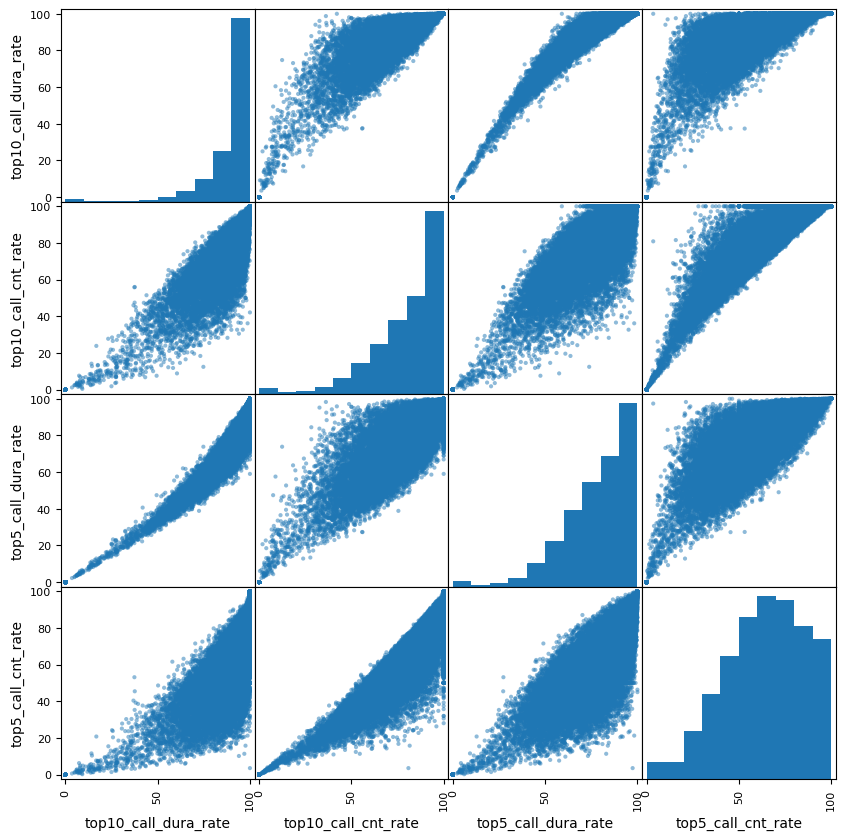

In [129]:
scatter_matrix(data[attributes], figsize=(10,10))
# top5/10的通话时长/次数呈现线性相关关系

对于存在共线性的属性，采用相除的组合方式，创建新的有意义的属性；    
但是由于这3个新属性在计算时均存在除数(night_call_cnt_rate、top5_call_cnt_rate、top10_call_cnt_rate)为0的情况，考虑将这除数为0的行去除，   
但是又由于欺诈用户大部分的night_call_cnt_rate均为0，直接丢弃会造成本身就少的正例丢失，且丢弃行的行为本就是下下策，还会导致在测试集中分类器无法处理night_call_cnt_rate为0的数据;    
一种方案是将0取为0.00001；    
另一种方案是不以相除的方式处理共线性属性，选择其中与label相关性更大的那一个保留，或者根本不处理；    

共线性的属性不止    
night_call_dura_rate与night_call_cnt_rate、    
top5_call_dura_rate与top5_call_cnt_rate、    
top10_call_dura_rate与top10_call_cnt_rate，    
更甚者还有    
top5_call_dura_rate与top10_call_dura_rate、    
top5_call_cnt_rate与top10_call_cnt_rate

In [1907]:
data['night_call_avg_dura_rate'] = data['night_call_dura_rate']/data['night_call_cnt_rate']
data['top5_call_avg_dura_rate'] = data['top5_call_dura_rate']/data['top5_call_cnt_rate']
data['top10_call_avg_dura_rate'] = data['top10_call_dura_rate']/data['top10_call_cnt_rate']

In [1908]:
data.iloc[:, -3:].describe()

,night_call_avg_dura_rate,top5_call_avg_dura_rate,top10_call_avg_dura_rate
count,2.842800e+04,29151.000000,29151.000000
mean,inf,1.339832,1.167311
std,NaN,0.542278,0.314712
min,2.400024e-03,0.515095,0.670095
25%,2.764095e-01,1.061518,1.016656
50%,5.694425e-01,1.189145,1.086578
75%,1.101539e+00,1.428860,1.205130
max,inf,27.414557,22.601973


对于标签不平衡的解决方法：    
- 模型层面决定选择bagging、boosting类模型
- 数据层面的过采样、欠采样等方法暂不考虑

# 数据准备

In [1912]:
data = train.copy()

In [1913]:
data

,age,sex,is_camp_user,night_call_dura_rate,night_call_cnt_rate,called_cnt_rate,contact_ratio,once_numbers,once_numbers_rate,top5_call_dura_rate,top5_call_cnt_rate,top5_opp_belo_cnt,top10_call_dura_rate,top10_call_cnt_rate,top10_opp_belo_cnt,label
0,25,2,0,1.2726,3.1250,87.5000,1,2,66.6667,72.0020,43.7500,3,86.5884,62.5000,3,0
1,18,2,0,8.4315,6.9767,76.7442,3,3,50.0000,99.2148,88.3721,1,100.0000,100.0000,3,0
2,42,1,1,5.0105,7.6923,49.0385,7,13,65.0000,64.1474,53.8462,2,82.2526,71.1538,3,0
3,28,2,1,1.4925,3.8462,19.2308,0,21,100.0000,45.9242,19.2308,1,64.0643,38.4615,1,0
4,60,1,0,0.7424,0.6472,37.5405,15,12,37.5000,69.9878,57.2816,3,85.1415,70.8738,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29404,22,2,0,6.3073,20.0000,100.0000,0,0,0.0000,100.0000,100.0000,3,100.0000,100.0000,3,0
29405,0,1,1,5.4694,6.1224,43.8776,5,1,20.0000,99.0246,89.7959,3,99.8302,97.9592,3,0
29406,18,1,0,4.6768,7.4074,48.1481,4,13,54.1667,45.3232,27.1605,1,62.7430,41.9753,1,0
29407,34,1,0,0.3208,0.7299,27.7372,9,7,35.0000,82.2456,62.7737,2,91.2374,74.4526,2,0


In [1924]:
X = data.drop(columns=['label'])
y = data['label']

- 对比率去除%的单位影响：除100
- 对年龄做min-max归一化
- 对contact_ratio做min-max归一化
- 对归属地数量做min-max归一化
- 对once_numbers做min-max归一化

In [1925]:
min_max_scale_cols = ['age', 'contact_ratio', 'once_numbers', 'top5_opp_belo_cnt', 'top10_opp_belo_cnt']

In [1926]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [1927]:
class KillPercentage(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        res = X.copy()
        for col in res.columns:
            if 'rate' in col and 'avg' not in col:
                res[col] = res[col]/100
        return res

In [1928]:
k_p = KillPercentage()

In [1929]:
k_p.fit_transform(X)

,age,sex,is_camp_user,night_call_dura_rate,night_call_cnt_rate,called_cnt_rate,contact_ratio,once_numbers,once_numbers_rate,top5_call_dura_rate,top5_call_cnt_rate,top5_opp_belo_cnt,top10_call_dura_rate,top10_call_cnt_rate,top10_opp_belo_cnt
0,25,2,0,0.012726,0.031250,0.875000,1,2,0.666667,0.720020,0.437500,3,0.865884,0.625000,3
1,18,2,0,0.084315,0.069767,0.767442,3,3,0.500000,0.992148,0.883721,1,1.000000,1.000000,3
2,42,1,1,0.050105,0.076923,0.490385,7,13,0.650000,0.641474,0.538462,2,0.822526,0.711538,3
3,28,2,1,0.014925,0.038462,0.192308,0,21,1.000000,0.459242,0.192308,1,0.640643,0.384615,1
4,60,1,0,0.007424,0.006472,0.375405,15,12,0.375000,0.699878,0.572816,3,0.851415,0.708738,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29404,22,2,0,0.063073,0.200000,1.000000,0,0,0.000000,1.000000,1.000000,3,1.000000,1.000000,3
29405,0,1,1,0.054694,0.061224,0.438776,5,1,0.200000,0.990246,0.897959,3,0.998302,0.979592,3
29406,18,1,0,0.046768,0.074074,0.481481,4,13,0.541667,0.453232,0.271605,1,0.627430,0.419753,1
29407,34,1,0,0.003208,0.007299,0.277372,9,7,0.350000,0.822456,0.627737,2,0.912374,0.744526,2


In [1930]:
class MyScaler(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
        return None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        res = X.copy()
        scaler = MinMaxScaler()
        res.loc[:, self.cols] = scaler.fit_transform(res.loc[:, self.cols])
        return res
        

In [1931]:
myscaler = MyScaler(min_max_scale_cols)

In [1932]:
myscaler.fit_transform(X)

,age,sex,is_camp_user,night_call_dura_rate,night_call_cnt_rate,called_cnt_rate,contact_ratio,once_numbers,once_numbers_rate,top5_call_dura_rate,top5_call_cnt_rate,top5_opp_belo_cnt,top10_call_dura_rate,top10_call_cnt_rate,top10_opp_belo_cnt
0,0.213675,2,0,1.2726,3.1250,87.5000,0.002882,0.000613,66.6667,72.0020,43.7500,0.6,86.5884,62.5000,0.3
1,0.153846,2,0,8.4315,6.9767,76.7442,0.008646,0.000920,50.0000,99.2148,88.3721,0.2,100.0000,100.0000,0.3
2,0.358974,1,1,5.0105,7.6923,49.0385,0.020173,0.003988,65.0000,64.1474,53.8462,0.4,82.2526,71.1538,0.3
3,0.239316,2,1,1.4925,3.8462,19.2308,0.000000,0.006442,100.0000,45.9242,19.2308,0.2,64.0643,38.4615,0.1
4,0.512821,1,0,0.7424,0.6472,37.5405,0.043228,0.003681,37.5000,69.9878,57.2816,0.6,85.1415,70.8738,0.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29404,0.188034,2,0,6.3073,20.0000,100.0000,0.000000,0.000000,0.0000,100.0000,100.0000,0.6,100.0000,100.0000,0.3
29405,0.000000,1,1,5.4694,6.1224,43.8776,0.014409,0.000307,20.0000,99.0246,89.7959,0.6,99.8302,97.9592,0.3
29406,0.153846,1,0,4.6768,7.4074,48.1481,0.011527,0.003988,54.1667,45.3232,27.1605,0.2,62.7430,41.9753,0.1
29407,0.290598,1,0,0.3208,0.7299,27.7372,0.025937,0.002147,35.0000,82.2456,62.7737,0.4,91.2374,74.4526,0.2


In [1933]:
_.describe()

,age,sex,is_camp_user,night_call_dura_rate,night_call_cnt_rate,called_cnt_rate,contact_ratio,once_numbers,once_numbers_rate,top5_call_dura_rate,top5_call_cnt_rate,top5_opp_belo_cnt,top10_call_dura_rate,top10_call_cnt_rate,top10_opp_belo_cnt
count,29409.000000,29409.000000,29409.000000,29409.000000,29409.000000,29409.000000,29409.000000,29409.000000,29409.000000,29409.000000,29409.000000,29409.000000,29409.000000,29409.000000,29409.000000
mean,0.332343,1.437145,0.152334,6.363872,6.413430,54.902482,0.017208,0.002807,50.161633,78.063901,63.742208,0.354721,89.729674,80.216229,0.241504
std,0.123169,0.516132,0.359351,12.279179,9.553943,19.472407,0.019233,0.013915,24.079010,18.532458,22.256341,0.179600,14.951446,19.569954,0.138494
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.239316,1.000000,0.000000,0.537600,1.492500,43.478300,0.005764,0.000613,35.714300,67.859700,48.507500,0.200000,85.957200,70.192300,0.100000
50%,0.333333,1.000000,0.000000,1.886800,3.333300,54.567300,0.011527,0.001534,50.000000,81.827300,65.306100,0.400000,94.958600,84.729100,0.200000
75%,0.427350,2.000000,0.000000,6.142100,7.407400,66.666700,0.023055,0.002761,64.864900,92.579600,80.663000,0.400000,99.419400,96.103900,0.300000
max,1.000000,3.000000,1.000000,100.000000,100.000000,100.000000,1.000000,1.000000,100.000000,100.000000,100.000000,1.000000,100.000000,100.000000,1.000000


数据处理流水线

In [1935]:
from sklearn.pipeline import Pipeline

In [1936]:
num_pipeline = Pipeline([
    ('kill_percentage',KillPercentage()),
    ('min_max_scaler', MyScaler(min_max_scale_cols))])

In [1937]:
data = train.copy()
X = data.drop(columns=['label'])
y = data['label']

In [1938]:
X_train = num_pipeline.fit_transform(X)
y_train = y

In [1939]:
train_processed = pd.concat([X_train, y_train], axis=1)

In [1940]:
train_processed

,age,sex,is_camp_user,night_call_dura_rate,night_call_cnt_rate,called_cnt_rate,contact_ratio,once_numbers,once_numbers_rate,top5_call_dura_rate,top5_call_cnt_rate,top5_opp_belo_cnt,top10_call_dura_rate,top10_call_cnt_rate,top10_opp_belo_cnt,label
0,0.213675,2,0,0.012726,0.031250,0.875000,0.002882,0.000613,0.666667,0.720020,0.437500,0.6,0.865884,0.625000,0.3,0
1,0.153846,2,0,0.084315,0.069767,0.767442,0.008646,0.000920,0.500000,0.992148,0.883721,0.2,1.000000,1.000000,0.3,0
2,0.358974,1,1,0.050105,0.076923,0.490385,0.020173,0.003988,0.650000,0.641474,0.538462,0.4,0.822526,0.711538,0.3,0
3,0.239316,2,1,0.014925,0.038462,0.192308,0.000000,0.006442,1.000000,0.459242,0.192308,0.2,0.640643,0.384615,0.1,0
4,0.512821,1,0,0.007424,0.006472,0.375405,0.043228,0.003681,0.375000,0.699878,0.572816,0.6,0.851415,0.708738,0.3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29404,0.188034,2,0,0.063073,0.200000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.6,1.000000,1.000000,0.3,0
29405,0.000000,1,1,0.054694,0.061224,0.438776,0.014409,0.000307,0.200000,0.990246,0.897959,0.6,0.998302,0.979592,0.3,0
29406,0.153846,1,0,0.046768,0.074074,0.481481,0.011527,0.003988,0.541667,0.453232,0.271605,0.2,0.627430,0.419753,0.1,0
29407,0.290598,1,0,0.003208,0.007299,0.277372,0.025937,0.002147,0.350000,0.822456,0.627737,0.4,0.912374,0.744526,0.2,0


In [1941]:
train_processed.describe()

,age,sex,is_camp_user,night_call_dura_rate,night_call_cnt_rate,called_cnt_rate,contact_ratio,once_numbers,once_numbers_rate,top5_call_dura_rate,top5_call_cnt_rate,top5_opp_belo_cnt,top10_call_dura_rate,top10_call_cnt_rate,top10_opp_belo_cnt,label
count,29409.000000,29409.000000,29409.000000,29409.000000,29409.000000,29409.000000,29409.000000,29409.000000,29409.000000,29409.000000,29409.000000,29409.000000,29409.000000,29409.000000,29409.000000,29409.000000
mean,0.332343,1.437145,0.152334,0.063639,0.064134,0.549025,0.017208,0.002807,0.501616,0.780639,0.637422,0.354721,0.897297,0.802162,0.241504,0.054779
std,0.123169,0.516132,0.359351,0.122792,0.095539,0.194724,0.019233,0.013915,0.240790,0.185325,0.222563,0.179600,0.149514,0.195700,0.138494,0.227553
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.239316,1.000000,0.000000,0.005376,0.014925,0.434783,0.005764,0.000613,0.357143,0.678597,0.485075,0.200000,0.859572,0.701923,0.100000,0.000000
50%,0.333333,1.000000,0.000000,0.018868,0.033333,0.545673,0.011527,0.001534,0.500000,0.818273,0.653061,0.400000,0.949586,0.847291,0.200000,0.000000
75%,0.427350,2.000000,0.000000,0.061421,0.074074,0.666667,0.023055,0.002761,0.648649,0.925796,0.806630,0.400000,0.994194,0.961039,0.300000,0.000000
max,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# 模型检索（使用默认超参数）

因为是有监督的二分类任务，考虑下列模型：
- 逻辑回归
- SVM分类
- 决策树
- 随机森林
- XGBoost
- LightGBM

手动交叉验证

In [1942]:
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.base import clone
from sklearn.metrics import precision_score, recall_score, fbeta_score, precision_recall_curve, roc_auc_score

In [ ]:
def my_cross_val_score(model, X_train, y_train, isStratified=True, usePredProb=False):
    if isStratified:
        skfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    else:
        skfolds = KFold(n_splits=5, shuffle=True, random_state=42)
        
    scores = {'precision': [],
              'recall': [],
              'fbeta_score': []}
    y_pred_prb = np.zeros(shape=y_train.shape)
    
    for train_indices, valid_indices in skfolds.split(X_train, y_train):
        clone_clf = clone(model)

        X_train_fold = X_train.iloc[train_indices, :]
        y_train_fold = y_train.iloc[train_indices]
        X_valid_fold = X_train.iloc[valid_indices, :]
        y_valid_fold = y_train.iloc[valid_indices]

        clone_clf.fit(X_train_fold, y_train_fold)
        
        y_pred = clone_clf.predict(X_valid_fold)
        if usePredProb:
            y_pred_prb[valid_indices] = clone_clf.predict_proba(X_valid_fold)[:,1]
        else:
            y_pred_prb[valid_indices] = clone_clf.decision_function(X_valid_fold)
        
        scores['precision'].append(precision_score(y_valid_fold, y_pred))
        scores['recall'].append(recall_score(y_valid_fold, y_pred))
        scores['fbeta_score'].append(fbeta_score(y_valid_fold, y_pred, beta=2))
    
    print("5折交叉验证的结果为: \n precision: {}({}) \n recall: {}({}) \n fbeta_score: {}({})".format(np.mean(scores['precision']),
                                                                                                    np.std(scores['precision']),
                                                                                                    np.mean(scores['recall']),
                                                                                                    np.std(scores['recall']),
                                                                                                    np.mean(scores['fbeta_score']),
                                                                                                    np.std(scores['fbeta_score'])))
    scores['auc'] = roc_auc_score(y_train, y_pred_prb)
    print(" auc: {}".format(scores['auc']))
    
    precisions, recalls, thresholds = precision_recall_curve(y_train, y_pred_prb)
    scores['p_r_curve'] = (precisions, recalls, thresholds)
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    plt.plot(recalls, precisions)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.grid()
    ax.set_title("P-R Curve")
    
    # fig = plt.figure()
    # ax = fig.add_subplot(1,1,1)
    # plt.plot(thresholds, precisions[:-1], "b--", label='Precision')
    # plt.plot(thresholds, recalls[:-1], "g-", label='Recall')
    # ax.legend()
    # ax.set_xlabel('thresholds')
    # ax.grid()
    
    return scores

### Logistic_Regression

In [1944]:
logistic_reg = LogisticRegression(max_iter=1000)

5折交叉验证的结果为: 
 precision: 0.9703596540513215(0.020711436117254425) 
 recall: 0.3562890602465242(0.015231142644846467) 
 fbeta_score: 0.40782442175148603(0.015762469950208958)
 auc: 0.8183345764506904


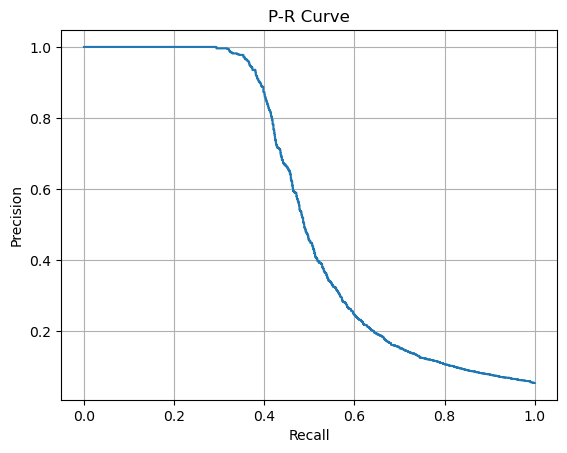

In [1947]:
scores_lr = my_cross_val_score(logistic_reg, X_train, y_train)

P-R曲线呈现梯形；

### SVM

In [1950]:
from sklearn.svm import SVC

In [1951]:
svc = SVC()

5折交叉验证的结果为: 
 precision: 0.9964887964887964(0.004302809499422516) 
 recall: 0.3382958675461031(0.014212604242965133) 
 fbeta_score: 0.38973038063304183(0.014990491814358058)
 auc: 0.852885691395435


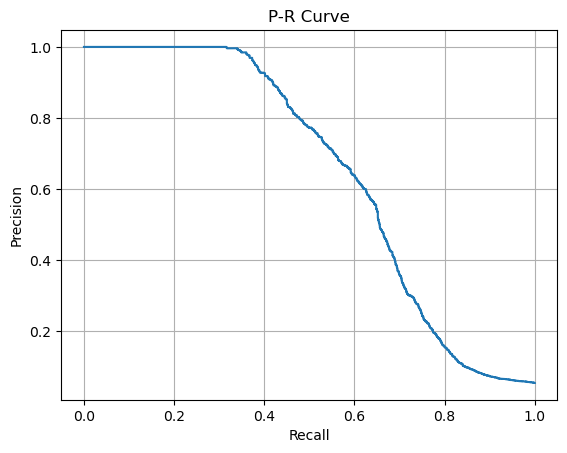

In [1952]:
scores_svc = my_cross_val_score(svc, X_train, y_train)

### Decision_Tree

In [1959]:
from sklearn.tree import DecisionTreeClassifier

In [1960]:
dtc = DecisionTreeClassifier()

5折交叉验证的结果为: 
 precision: 0.7094997715598055(0.015290799903484158) 
 recall: 0.7448589504451666(0.02482091715281345) 
 fbeta_score: 0.7371915651975152(0.017149547808941488)
 auc: 0.8635719341570732


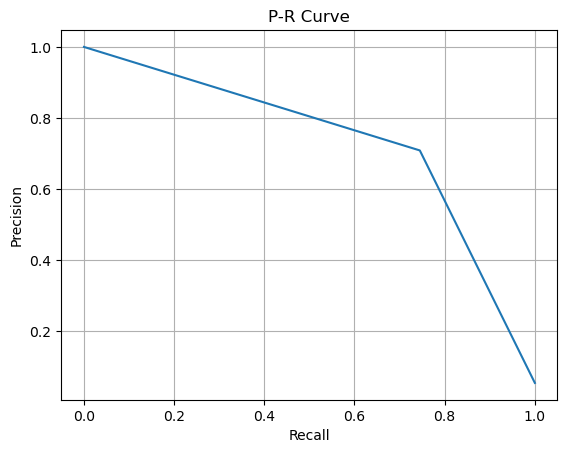

In [1961]:
scores_dtc = my_cross_val_score(dtc, X_train, y_train, usePredProb=True)

### bagging: random_forest

In [1962]:
from sklearn.ensemble import RandomForestClassifier

In [1963]:
rfc = RandomForestClassifier()

5折交叉验证的结果为: 
 precision: 0.9906861448909892(0.0071633893098126825) 
 recall: 0.7206488087225736(0.02271240382259785) 
 fbeta_score: 0.7620921623735828(0.0202171308950092)
 auc: 0.9294114443344463


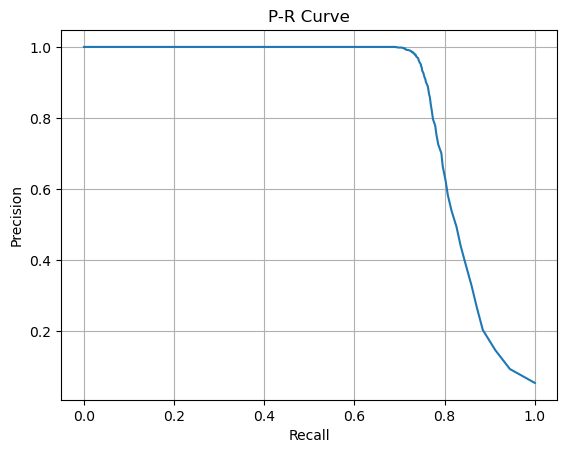

In [1964]:
scores_rfc = my_cross_val_score(rfc, X_train, y_train, usePredProb=True)

查看特征重要性

In [1965]:
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [1966]:
importance_dic = {}
for importance, feature_name in zip(rfc.feature_importances_, X_train.columns):
    importance_dic[feature_name] = [importance]

In [1967]:
importance_dic

{'age': [0.02979293066863437],
 'sex': [0.004655092154028304],
 'is_camp_user': [0.002369401714404756],
 'night_call_dura_rate': [0.24321457243667566],
 'night_call_cnt_rate': [0.27038584724987047],
 'called_cnt_rate': [0.03546073048271153],
 'contact_ratio': [0.02070989827484687],
 'once_numbers': [0.0431563135539934],
 'once_numbers_rate': [0.021294495773851372],
 'top5_call_dura_rate': [0.060610743885030224],
 'top5_call_cnt_rate': [0.05479878917372049],
 'top5_opp_belo_cnt': [0.028195199939252204],
 'top10_call_dura_rate': [0.053140322349074835],
 'top10_call_cnt_rate': [0.0726792626884249],
 'top10_opp_belo_cnt': [0.059536399655480736]}

In [1968]:
pd.DataFrame(data=importance_dic.values(), index=importance_dic.keys(),columns=['importance']).sort_values(by=['importance'], ascending=False)
# 可以看到night_call_cnt_rate和label的贡献最大，之前把night_call_cnt_rate=0的行全部删除，导致fbeta只有0.3-0.4

,importance
night_call_cnt_rate,0.270386
night_call_dura_rate,0.243215
top10_call_cnt_rate,0.072679
top5_call_dura_rate,0.060611
top10_opp_belo_cnt,0.059536
top5_call_cnt_rate,0.054799
top10_call_dura_rate,0.053140
once_numbers,0.043156
called_cnt_rate,0.035461
age,0.029793


可以看到sex和is_camp_user的贡献小了一个数量级，说明一个人是否从事电信诈骗和ta的性别、是否在校关系不大；    
考虑改进时去除这两个属性；

若考虑丢弃共线性属性的方案，则可以丢弃night_call_dura_rate、top5_call_cnt_rate、top10_call_dura_rate

### boosting: XGBoost、LightGBM

In [1969]:
import xgboost
from xgboost.sklearn import XGBClassifier

In [1970]:
xgb_clf = XGBClassifier()

5折交叉验证的结果为: 
 precision: 0.9733893037956746(0.012642188199418217) 
 recall: 0.7367978770455551(0.02396280246905756) 
 fbeta_score: 0.7742590724824525(0.02007589654972674)
 auc: 0.9323245526418777


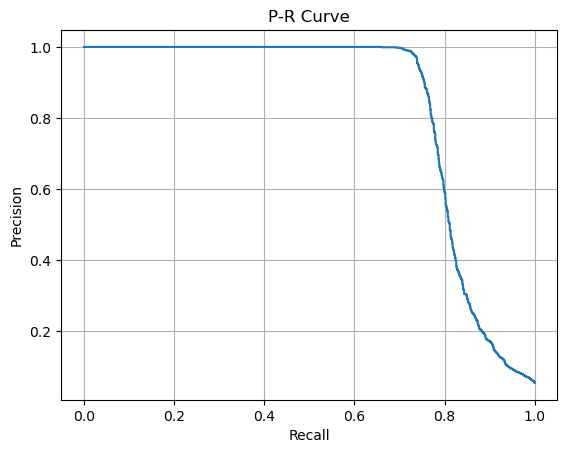

In [1971]:
scores_xgb = my_cross_val_score(xgb_clf, X_train, y_train, usePredProb=True)

In [1972]:
from lightgbm.sklearn import LGBMClassifier

In [1973]:
lgb_clf = LGBMClassifier()

5折交叉验证的结果为: 
 precision: 0.9734841366506952(0.013273398234244956) 
 recall: 0.7355517950887449(0.02360064807306418) 
 fbeta_score: 0.773146469191143(0.019261160915256648)
 auc: 0.9392922176119471


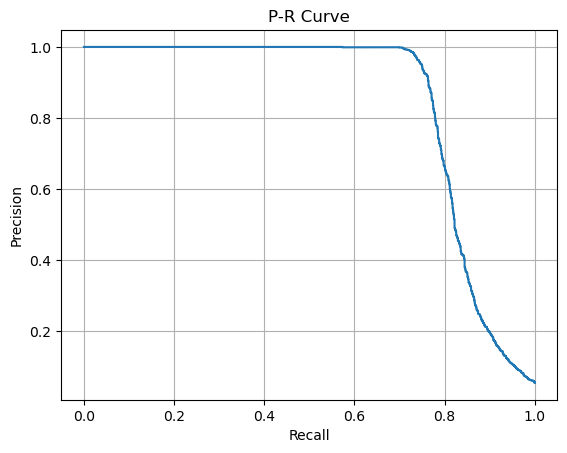

In [1974]:
scores_lgb = my_cross_val_score(lgb_clf, X_train, y_train, usePredProb=True)

查看f2排名

In [1975]:
scores_dic = {
              'logistic_reg': scores_lr,
              'svc': scores_svc,
              'decision_tree': scores_dtc,
              'random_forest': scores_rfc,
              'xgb':scores_xgb,
              'lgb': scores_lgb,
}

In [1976]:
fbeta_scores_dic = {}
for model_name, scores in scores_dic.items():
    fbeta_scores_dic[model_name] =  np.mean(scores['fbeta_score'])

In [1977]:
pd.DataFrame(data=fbeta_scores_dic.values(), index=fbeta_scores_dic.keys(), columns=['f2']).sort_values(by=['f2'], ascending=False)

,f2
xgb,0.774259
lgb,0.773146
random_forest,0.762092
decision_tree,0.737192
logistic_reg,0.407824
svc,0.385886


### voting

In [1978]:
from sklearn.ensemble import VotingClassifier

In [1987]:
logistic_reg = LogisticRegression(max_iter=1000)
svc = SVC(probability=True)
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()
xgb_clf = XGBClassifier()
lgb_clf = LGBMClassifier()

使用网格搜索来来寻找最佳的集成

In [1988]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [1989]:
param_grid = [{'estimators': [
                # 集成全部模型
                [('lr', logistic_reg), 
                ('svm', svc),
                ('dtc', dtc),
                ('rfc', rfc),
                ('xgb', xgb_clf),
                ('lgb', lgb_clf)],
                # 仅集成在f2上表现好的前4名
                [('decision_tree', dtc),
                 ('rfc', rfc),
                 ('xgb', xgb_clf),
                 ('lgb', lgb_clf)],
                # 仅集成在recall上表现好的前3名
                [('rfc', rfc),
                 ('xgb', xgb_clf),
                 ('lgb', lgb_clf)]]}]

In [1990]:
voting_clf = VotingClassifier(estimators=[], voting='soft')

In [1991]:
def myfbeta(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)

In [1992]:
fbeta = make_scorer(myfbeta, greater_is_better=True)

In [1993]:
grid_search = GridSearchCV(voting_clf, param_grid, cv=5, scoring=fbeta, return_train_score=True)

In [1994]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=VotingClassifier(estimators=[], voting='soft'),
             param_grid=[{'estimators': [[('lr',
                                           LogisticRegression(max_iter=1000)),
                                          ('svm', SVC(probability=True)),
                                          ('dtc', DecisionTreeClassifier()),
                                          ('rfc', RandomForestClassifier()),
                                          ('xgb',
                                           XGBClassifier(base_score=None,
                                                         booster=None,
                                                         callbacks=None,
                                                         colsample_bylevel=None,
                                                         colsample_bynode=None,
                                                         c...
                                                         learning_rate=None,
                                                         max_bin=None,
                                                         max_cat_threshold=None,
                                                         max_cat_to_onehot=None,
                                                         max_delta_step=None,
                                                         max_depth=None,
                                                         max_leaves=None,
                                                         min_child_weight=None,
                                                         missing=nan,
                                                         monotone_constraints=None,
                                                         n_estimators=100,
                                                         n_jobs=None,
                                                         num_parallel_tree=None,
                                                         predictor=None,
                                                         random_state=None, ...)),
                                          ('lgb', LGBMClassifier())]]}],
             return_train_score=True, scoring=make_scorer(myfbeta))

In [1995]:
grid_search.best_params_

{'estimators': [('decision_tree', DecisionTreeClassifier()),
  ('rfc', RandomForestClassifier()),
  ('xgb',
   XGBClassifier(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=None, early_stopping_rounds=None,
                 enable_categorical=False, eval_metric=None, feature_types=None,
                 gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=None, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=None, max_leaves=None,
                 min_child_weight=None, missing=nan, monotone_constraints=None,
                 n_estimators=100, n_jobs=None, num_parallel_tree=None,
                 predictor=None, random_state=None, ...)),
  ('lgb', LGBMClassifier())]}

In [1996]:
cvres = grid_search.cv_results_

In [1997]:
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(mean_score, params)

0.7678203207183283 {'estimators': [('lr', LogisticRegression(max_iter=1000)), ('svm', SVC(probability=True)), ('dtc', DecisionTreeClassifier()), ('rfc', RandomForestClassifier()), ('xgb', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)), ('lgb', LGBMClassifier())]}
0.7735898474780736 {'estimator

最好的集成是仅集成在f2上表现好的前4名

再看看这三者的P-R曲线

In [2000]:
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()
xgb_clf = XGBClassifier()
lgb_clf = LGBMClassifier()

voting_clf = VotingClassifier(
    estimators=[('decision_tree', dtc),
                 ('rfc', rfc),
                 ('xgb', xgb_clf),
                 ('lgb', lgb_clf)],
    voting='soft')

5折交叉验证的结果为: 
 precision: 0.9782716878604708(0.014137861303257003) 
 recall: 0.7343095590639(0.023460909715640774) 
 fbeta_score: 0.7726505779393882(0.019275258694734423)
 auc: 0.9368068984326896


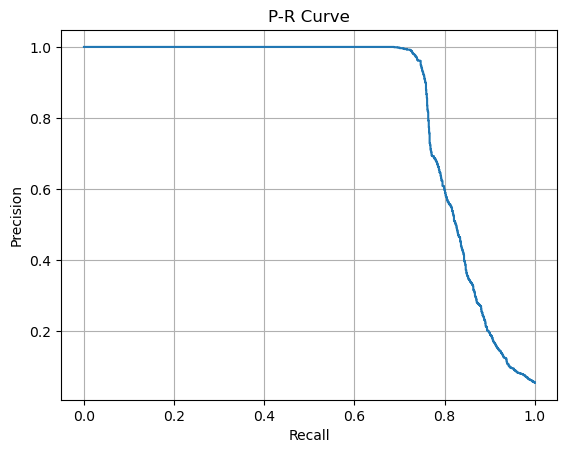

In [2001]:
scores_voting = my_cross_val_score(voting_clf, X_train, y_train, usePredProb=True)

In [2002]:
logistic_reg = LogisticRegression(max_iter=1000)
svc = SVC(probability=True)
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()
xgb_clf = XGBClassifier()
lgb_clf = LGBMClassifier()

voting_clf2 = VotingClassifier(
    estimators=[('lr', logistic_reg), 
                ('svm', svc),
                ('dtc', dtc),
                ('rfc', rfc),
                ('xgb', xgb_clf),
                ('lgb', lgb_clf)],
    voting='soft')


rfc = RandomForestClassifier()
xgb_clf = XGBClassifier()
lgb_clf = LGBMClassifier()

voting_clf3 = VotingClassifier(
    estimators=[('rfc', rfc),
                 ('xgb', xgb_clf),
                 ('lgb', lgb_clf)],
    voting='soft')

5折交叉验证的结果为: 
 precision: 0.9859642577743012(0.007633502768331546) 
 recall: 0.729342537930504(0.023866211949483015) 
 fbeta_score: 0.7692442970501114(0.020592602518920984)
 auc: 0.9336506710265764
5折交叉验证的结果为: 
 precision: 0.9877271426649701(0.009349496571589606) 
 recall: 0.731830855912159(0.02342279401236874) 
 fbeta_score: 0.7716676723700087(0.020008934195703054)
 auc: 0.9382642062276987


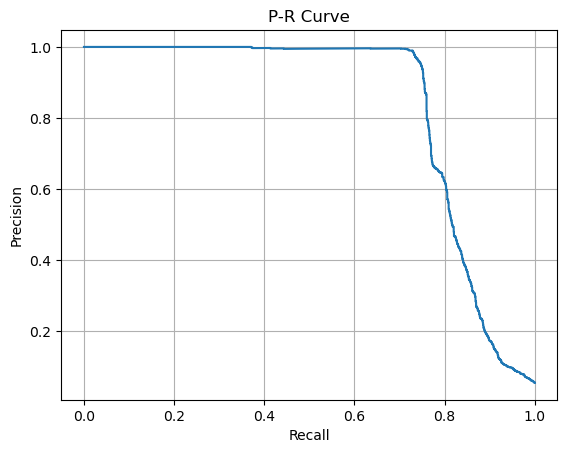

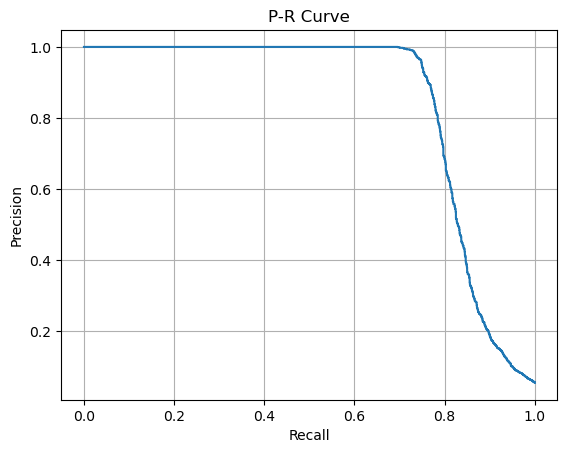

In [2003]:
scores_voting2 = my_cross_val_score(voting_clf2, X_train, y_train, usePredProb=True)
scores_voting3 = my_cross_val_score(voting_clf3, X_train, y_train, usePredProb=True)

In [2004]:
def draw_p_r_curve(scores_dic):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(1,1,1)
    for index, (model_name, model_scores) in enumerate(scores_dic.items()):
        p, r, t = model_scores['p_r_curve']
        plt.plot(r, p, 'C{}'.format(index), label=model_name)
        
    x = np.arange(0, 1.2, 0.2)
    y = x
    plt.plot(x, y, 'k--', alpha=0.5)    
    
    ax.grid()
    ax.legend()
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('P-R curve')
    plt.show()

In [2005]:
scores_dic = {
              # 'logistic_reg': scores_lr,
              # 'svc': scores_svc,
              # 'decision_tree': scores_dtc,
              # 'random_forest': scores_rfc,
              # 'xgb':scores_xgb,
              # 'lgb': scores_lgb,
              'voting(tree+rf+xgb+lgb)': scores_voting,
              'voting(all)': scores_voting2,
              'voting(rf+lgb+xgb)': scores_voting3
}

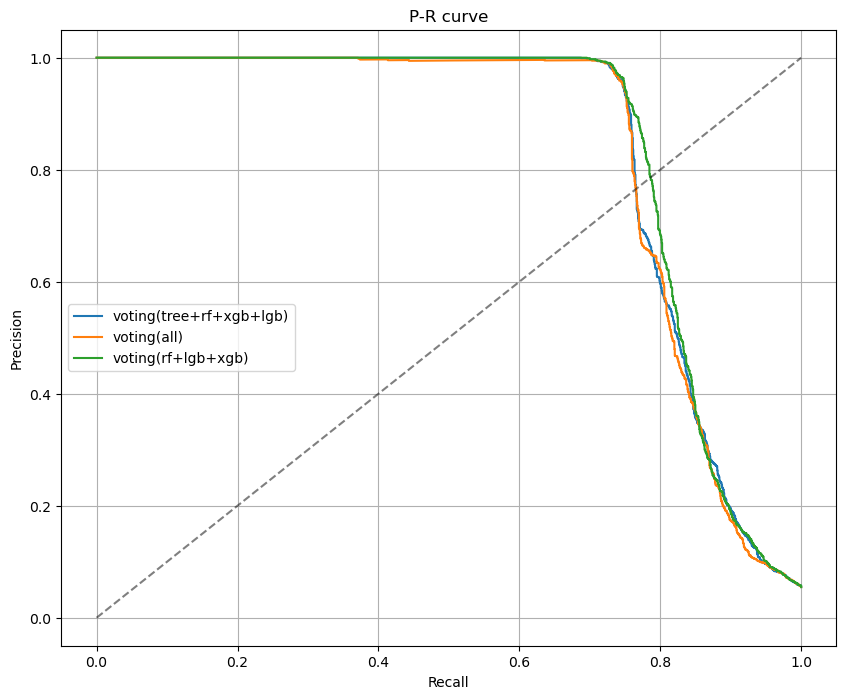

In [2006]:
draw_p_r_curve(scores_dic)

从P-R曲线上看似乎选前3也是不错的选择，不过本实验还是选择前4做集成

In [2117]:
scores_dic = {
              'logistic_reg': scores_lr,
              'svc': scores_svc,
              'decision_tree': scores_dtc,
              'random_forest': scores_rfc,
              'xgb':scores_xgb,
              'lgb': scores_lgb,
              'voting(dtc+rf+xgb+lgb)': scores_voting,
}

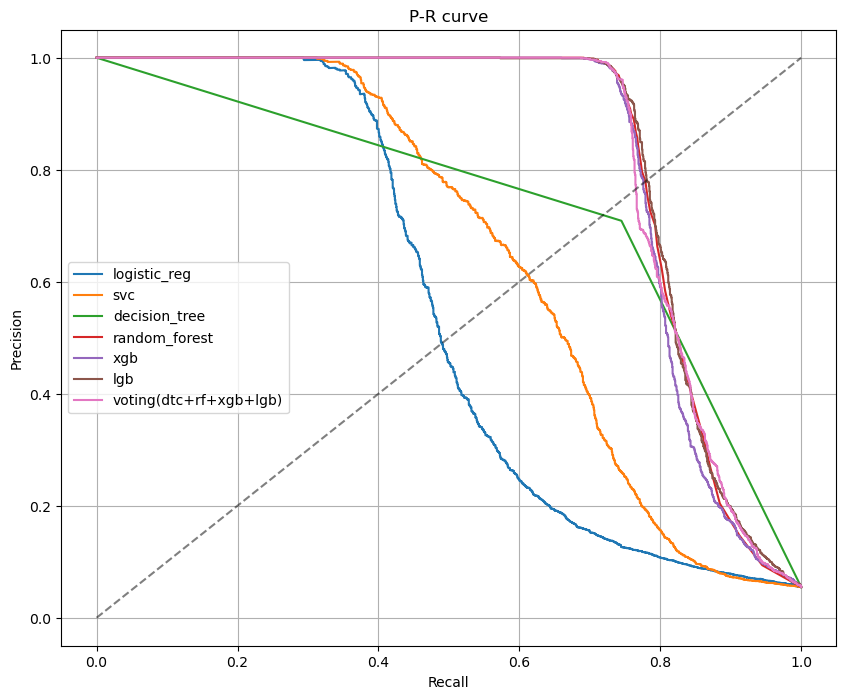

In [2118]:
draw_p_r_curve(scores_dic)

逻辑回归和svm可以直接淘汰，因为它俩被后面使用集成方法的模型完全包住

- 根据平衡点对各模型的排名:    
lgb > random_forest > xgb > voting > decision_tree > svc > logistic_reg

- 当precision设置为0.2时，recall的排名:   
decision_tree > lgb > voting > random_forest > xgb > svc > logistic_reg

最后选择lgb模型作为最终模型

# 微调

In [2018]:
from sklearn.pipeline import Pipeline

In [2019]:
num_pipeline = Pipeline([
    ('kill_percentage',KillPercentage()),
    ('min_max_scaler', MyScaler(min_max_scale_cols))])

In [2020]:
data = train.copy()
X = data.drop(columns=['label'])
y = data['label']

In [2021]:
full_pipeline = Pipeline([
    ('data_process', num_pipeline),
    ('lgb',LGBMClassifier())
])

In [2022]:
full_pipeline.get_params()

{'memory': None,
 'steps': [('data_process',
   Pipeline(steps=[('kill_percentage', KillPercentage()),
                   ('min_max_scaler',
                    MyScaler(cols=['age', 'contact_ratio', 'once_numbers',
                                   'top5_opp_belo_cnt', 'top10_opp_belo_cnt']))])),
  ('lgb', LGBMClassifier())],
 'verbose': False,
 'data_process': Pipeline(steps=[('kill_percentage', KillPercentage()),
                 ('min_max_scaler',
                  MyScaler(cols=['age', 'contact_ratio', 'once_numbers',
                                 'top5_opp_belo_cnt', 'top10_opp_belo_cnt']))]),
 'lgb': LGBMClassifier(),
 'data_process__memory': None,
 'data_process__steps': [('kill_percentage', KillPercentage()),
  ('min_max_scaler',
   MyScaler(cols=['age', 'contact_ratio', 'once_numbers', 'top5_opp_belo_cnt',
                  'top10_opp_belo_cnt']))],
 'data_process__verbose': False,
 'data_process__kill_percentage': KillPercentage(),
 'data_process__min_max_scaler': MyScal

In [2023]:
param_grid = [{'lgb__learning_rate': [0.01, 0.03, 0.05, 0.1, 0.3], 'lgb__n_estimators': [100, 500, 1000] }]

In [2024]:
grid_search_final = GridSearchCV(estimator=full_pipeline,
                                 param_grid=param_grid,
                                 cv=5,
                                 scoring=fbeta,
                                 return_train_score=True,
                                 refit=True)

In [2025]:
grid_search_final.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('data_process',
                                        Pipeline(steps=[('kill_percentage',
                                                         KillPercentage()),
                                                        ('min_max_scaler',
                                                         MyScaler(cols=['age',
                                                                        'contact_ratio',
                                                                        'once_numbers',
                                                                        'top5_opp_belo_cnt',
                                                                        'top10_opp_belo_cnt']))])),
                                       ('lgb', LGBMClassifier())]),
             param_grid=[{'lgb__learning_rate': [0.01, 0.03, 0.05, 0.1, 0.3],
                          'lgb__n_estimators': [100, 500, 1000]}],
             return_train_score=True, scoring=make_scorer(myfbeta))

In [2026]:
grid_search_final.best_params_

{'lgb__learning_rate': 0.03, 'lgb__n_estimators': 1000}

In [2034]:
best_pipeline = grid_search_final.best_estimator_

In [2035]:
grid_search_final.best_score_

0.772185401748403

# 改进

- 改进方法：
1. 尝试丢弃共线性特征的方案；
2. 尝试丢弃贡献度不大的特征（根据random_forest的报告）

In [2089]:
class DropFakeAttr(BaseEstimator, TransformerMixin):
    def __init__(self, drop_cols=[]):
        self.drop_cols = drop_cols
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        res = X.copy()
        res.drop(axis=1, columns=self.drop_cols, inplace=True)
        return res
    

In [2090]:
dropper = DropFakeAttr(['sex', 'is_camp_user'])

In [2091]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ('kill_percentage',KillPercentage()),
    ('min_max_scaler', MyScaler(min_max_scale_cols)),
    ('drop_attr', DropFakeAttr())])

In [2092]:
data = train.copy()
X = data.drop(columns=['label'])
y = data['label']

In [2093]:
full_pipeline = Pipeline([
    ('data_process', num_pipeline),
    ('lgb',LGBMClassifier(learning_rate=0.03))
])

In [2094]:
full_pipeline.get_params()

{'memory': None,
 'steps': [('data_process',
   Pipeline(steps=[('kill_percentage', KillPercentage()),
                   ('min_max_scaler',
                    MyScaler(cols=['age', 'contact_ratio', 'once_numbers',
                                   'top5_opp_belo_cnt', 'top10_opp_belo_cnt'])),
                   ('drop_attr', DropFakeAttr())])),
  ('lgb', LGBMClassifier(learning_rate=0.03))],
 'verbose': False,
 'data_process': Pipeline(steps=[('kill_percentage', KillPercentage()),
                 ('min_max_scaler',
                  MyScaler(cols=['age', 'contact_ratio', 'once_numbers',
                                 'top5_opp_belo_cnt', 'top10_opp_belo_cnt'])),
                 ('drop_attr', DropFakeAttr())]),
 'lgb': LGBMClassifier(learning_rate=0.03),
 'data_process__memory': None,
 'data_process__steps': [('kill_percentage', KillPercentage()),
  ('min_max_scaler',
   MyScaler(cols=['age', 'contact_ratio', 'once_numbers', 'top5_opp_belo_cnt',
                  'top10_opp_belo_

In [2102]:
param_grid = [{'data_process__drop_attr__drop_cols': [[], ['sex', 'is_camp_user'], 
                                                      # ['night_call_dura_rate', 'top5_call_cnt_rate', 'top10_call_dura_rate'], 
                                                      ['sex', 'is_camp_user', 'night_call_dura_rate', 'top5_call_cnt_rate', 'top10_call_dura_rate']]}]

In [2103]:
grid_search_improve = GridSearchCV(estimator=full_pipeline,
                                   param_grid=param_grid,
                                   cv=5,
                                   scoring=fbeta,
                                   return_train_score=True,
                                   refit=True)

In [2104]:
grid_search_improve.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('data_process',
                                        Pipeline(steps=[('kill_percentage',
                                                         KillPercentage()),
                                                        ('min_max_scaler',
                                                         MyScaler(cols=['age',
                                                                        'contact_ratio',
                                                                        'once_numbers',
                                                                        'top5_opp_belo_cnt',
                                                                        'top10_opp_belo_cnt'])),
                                                        ('drop_attr',
                                                         DropFakeAttr())])),
                                       ('lgb',
                                        LGBMClassifier(learning_rate=0.03))]),
             param_grid=[{'data_process__drop_attr__drop_cols': [[],
                                                                 ['sex',
                                                                  'is_camp_user'],
                                                                 ['sex',
                                                                  'is_camp_user',
                                                                  'night_call_dura_rate',
                                                                  'top5_call_cnt_rate',
                                                                  'top10_call_dura_rate']]}],
             return_train_score=True, scoring=make_scorer(myfbeta))

In [2105]:
grid_search_improve.best_params_

{'data_process__drop_attr__drop_cols': ['sex', 'is_camp_user']}

In [2106]:
best_pipeline_improved = grid_search_improve.best_estimator_

In [2107]:
cvres = grid_search_improve.cv_results_

In [2108]:
for params, mean_test_score in zip(cvres['params'], cvres['mean_test_score']):
    print(params, mean_test_score)

{'data_process__drop_attr__drop_cols': []} 0.7709203512659968
{'data_process__drop_attr__drop_cols': ['sex', 'is_camp_user']} 0.7718603787500565
{'data_process__drop_attr__drop_cols': ['sex', 'is_camp_user', 'night_call_dura_rate', 'top5_call_cnt_rate', 'top10_call_dura_rate']} 0.7714658152019214


可以看到仅删除低贡献属性的效果最好；    
无论是否都删除or只删除其中一个（共线性属性、低贡献属性）的效果比什么都不做好；    

# 评估

In [2036]:
test = pd.read_csv('./data/test.csv')

In [2037]:
test

,age,sex,is_camp_user,night_call_dura_rate,night_call_cnt_rate,called_cnt_rate,contact_ratio,once_numbers,once_numbers_rate,top5_call_dura_rate,top5_call_cnt_rate,top5_opp_belo_cnt,top10_call_dura_rate,top10_call_cnt_rate,top10_opp_belo_cnt,label
0,35,1,0,3.3557,5.2083,64.5833,9,3,33.3333,78.0651,56.2500,1,92.1427,81.2500,1,0
1,44,1,0,2.3340,3.6000,59.6000,16,35,67.3077,28.4382,10.4000,1,46.2030,23.6000,1,0
2,30,1,0,3.1592,1.8868,41.5094,6,7,50.0000,55.2233,49.0566,1,79.0649,69.8113,1,0
3,67,1,0,0.0000,0.0000,50.0000,3,8,72.7273,82.8697,37.5000,2,93.3797,78.1250,2,1
4,29,1,0,2.8661,1.0791,44.2446,13,23,51.1111,57.4978,37.7698,1,71.5094,51.7986,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9729,62,2,0,1.0515,3.4483,58.6207,2,3,50.0000,87.0504,86.2069,2,100.0000,100.0000,2,0
9730,44,1,0,56.9288,66.6667,33.3333,0,4,100.0000,100.0000,100.0000,2,100.0000,100.0000,2,0
9731,53,1,0,0.6517,2.5510,44.6429,20,18,42.8571,46.6541,30.8673,1,72.6765,63.5204,1,0
9732,31,2,0,1.3945,1.8519,68.5185,5,3,27.2727,92.7083,87.6543,3,98.5047,96.9136,4,0


In [2038]:
X_test = test.drop(columns=['label'], axis=0)

In [2039]:
X_test

,age,sex,is_camp_user,night_call_dura_rate,night_call_cnt_rate,called_cnt_rate,contact_ratio,once_numbers,once_numbers_rate,top5_call_dura_rate,top5_call_cnt_rate,top5_opp_belo_cnt,top10_call_dura_rate,top10_call_cnt_rate,top10_opp_belo_cnt
0,35,1,0,3.3557,5.2083,64.5833,9,3,33.3333,78.0651,56.2500,1,92.1427,81.2500,1
1,44,1,0,2.3340,3.6000,59.6000,16,35,67.3077,28.4382,10.4000,1,46.2030,23.6000,1
2,30,1,0,3.1592,1.8868,41.5094,6,7,50.0000,55.2233,49.0566,1,79.0649,69.8113,1
3,67,1,0,0.0000,0.0000,50.0000,3,8,72.7273,82.8697,37.5000,2,93.3797,78.1250,2
4,29,1,0,2.8661,1.0791,44.2446,13,23,51.1111,57.4978,37.7698,1,71.5094,51.7986,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9729,62,2,0,1.0515,3.4483,58.6207,2,3,50.0000,87.0504,86.2069,2,100.0000,100.0000,2
9730,44,1,0,56.9288,66.6667,33.3333,0,4,100.0000,100.0000,100.0000,2,100.0000,100.0000,2
9731,53,1,0,0.6517,2.5510,44.6429,20,18,42.8571,46.6541,30.8673,1,72.6765,63.5204,1
9732,31,2,0,1.3945,1.8519,68.5185,5,3,27.2727,92.7083,87.6543,3,98.5047,96.9136,4


In [2040]:
y_test = test['label']

In [2041]:
y_pred = best_pipeline.predict(X_test)

In [2109]:
y_pred_improved = best_pipeline_improved.predict(X_test)

In [2042]:
# 改进前
fbeta_score(y_test, y_pred, beta=2)

0.7782927771340286

In [2110]:
# 改进后
fbeta_score(y_test, y_pred_improved, beta=2)

0.7805255023183927

In [2084]:
y_pred_prob = best_pipeline.predict_proba(X_test)

In [2112]:
y_pred_prob_improved = best_pipeline_improved.predict_proba(X_test)

In [2085]:
# 改进前
roc_auc_score(y_test, y_pred_prob[:,1])

0.9172682103309223

In [2113]:
# 改进后
roc_auc_score(y_test, y_pred_prob_improved[:,1])

0.9148196969212059

使用全量数据集之后评估指标飙升，说先前删除的那部分数据可能对预测有着至关重要的作用

因此摒弃删除invalid行的想法，重新训练模型

混淆矩阵

In [2045]:
from sklearn.metrics import confusion_matrix

In [2046]:
# 改进前
confusion_matrix(y_test, y_pred)

array([[9180,   10],
       [ 141,  403]], dtype=int64)

欺诈用户中有403位被检测出来，仍然有141位未被检测出

In [2114]:
# 改进后
confusion_matrix(y_test, y_pred_improved)

array([[9182,    8],
       [ 140,  404]], dtype=int64)

可以看到改进后的方案又多检测出了一个欺诈用户

# 后续改进

可以结合先前验证的猜想进一步改进

考虑    
top5_call_dura_rate与top10_call_dura_rate、    
top5_call_cnt_rate与top10_call_cnt_rate    
之间的共线性

性别转为one-hot